In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import os
import math
import spacy
sys.path.append("../")
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dhira.data.data_manager import DataManager
from dhira.data.embedding_manager import EmbeddingManager
from dhira.tf.models.siamese.siamese_bilstm import SiameseBiLSTM

from tqdm import tqdm_notebook as tqdm

nlp = spacy.load('en_core_web_md')

In [3]:
# from dhira.data.dataset.text import IndexedDataset
# from dhira.data.features.pair_feature import PairFeature
# quora_dataset = IndexedDataset(name='quora',
#                                train_files='../data/quora/processed/train_cleaned_train_split.csv',
#                                val_files='../data/quora/processed/train_cleaned_val_split.csv',
#                                test_files='../data/quora/processed/test_final.csv',
#                                feature_type=PairFeature,
#                                pad=True,
#                                pickle_dir='../models/',
#                                max_lengths={"num_sentence_words": 30})

In [4]:
from dhira.data.dataset.quora import QuoraDataset
from dhira.data.features.quora_feature import QuoraFeature
quora_dataset = QuoraDataset(name='quora-spacy',
                               train_files='../data/quora/processed/train_cleaned_train_split.csv',
                               val_files='../data/quora/processed/train_cleaned_val_split.csv',
                               test_files='../data/quora/processed/test_final.csv',
                               feature_type=QuoraFeature,
                               pad=True,
                               pickle_dir='../models/',
                               max_lengths={"num_sentence_words": 30},
                               spacy_nlp_pipeline=nlp)

INFO:dhira.data.dataset.quora:Trying to load prefitted data_indexer... quora-spacy-data_indexr.p
INFO:dhira.data.dataset.quora:Reusing the pickle file quora-spacy-data_indexr.p.


In [5]:
data_manager = DataManager(dataset=quora_dataset)

In [6]:
get_train_data_gen, train_data_size = data_manager.get_train_data_from_file()

INFO:dhira.data.dataset.quora:Getting training data from ../data/quora/processed/train_cleaned_train_split.csv
INFO:dhira.data.dataset.quora:Processing the train data file for first time
INFO:dhira.data.dataset.quora:Reading files ['../data/quora/processed/train_cleaned_train_split.csv'] to a list of lines.
100%|██████████| 363861/363861 [00:00<00:00, 1659266.61it/s]
INFO:dhira.data.dataset.quora:Creating list of <class 'dhira.data.features.quora_feature.QuoraFeature'> features from list of lines.
100%|██████████| 363861/363861 [09:06<00:00, 665.46it/s]
INFO:dhira.data.dataset.quora:Finished reading dataset; label counts: [(0, 229425), (1, 134436)]
INFO:dhira.data.data_indexer:Fitting word dictionary with min count of 1
100%|██████████| 363861/363861 [00:15<00:00, 23240.19it/s]
INFO:dhira.data.dataset.text:Converting to indexed features...
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.data.dataset.quora:Instance max lengths {'num_sentence_words': 271}
INFO:dhira.data.dataset.quora:Padding lengths to length: {'num_sentence_words': 30}


In [7]:
get_val_data_gen, val_data_size = data_manager.get_validation_data_from_file()

INFO:dhira.data.dataset.quora:Getting validation data from ../data/quora/processed/train_cleaned_val_split.csv
INFO:dhira.data.dataset.quora:Processing the validation data file for first time
INFO:dhira.data.dataset.quora:Reading files ['../data/quora/processed/train_cleaned_val_split.csv'] to a list of lines.
100%|██████████| 40429/40429 [00:00<00:00, 1719774.81it/s]
INFO:dhira.data.dataset.quora:Creating list of <class 'dhira.data.features.quora_feature.QuoraFeature'> features from list of lines.
100%|██████████| 40429/40429 [00:59<00:00, 684.27it/s]
INFO:dhira.data.dataset.quora:Finished reading dataset; label counts: [(0, 25602), (1, 14827)]
INFO:dhira.data.dataset.text:Converting to indexed features...
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.data.dataset.quora:Instance max lengths {'num_sentence_words': 271}
INFO:dhira.data.dataset.quora:Padding lengths to length: {'num_sentence_words': 30}


In [6]:
# embedding_manager = EmbeddingManager(quora_dataset.data_indexer, pickle_dir='../models/')
# embedding_matrix = embedding_manager.get_embedding_matrix(300,'../data/quora/external/glove.6B.300d.txt')
embedding_matrix = EmbeddingManager.get_spacy_embedding_matrix(nlp, quora_dataset.data_indexer)

In [7]:
embedding_matrix.shape

(115170, 300)

In [9]:
model = ''
model = SiameseBiLSTM(mode='train',
             save_dir='../models/',
             log_dir='../logs/',
             run_id='0',
             word_vocab_size=embedding_matrix.shape[0], 
             word_embedding_dim=300, 
             word_embedding_matrix=embedding_matrix, 
             fine_tune_embeddings=True, 
             share_encoder_weights=True,
             rnn_output_mode='last',
             output_keep_prob=0.5,
             rnn_hidden_size=256)



INFO:dhira.tf.models.base_tf_model:Writing logs to ../logs/SiameseBiLSTM/00


In [9]:
model.build_graph()

INFO:dhira.tf.models.base_tf_model:Writing params to ../logs/SiameseBiLSTM/00/trainparams.json
INFO:dhira.tf.models.base_tf_model:Building graph...
/home/mageswarand/anaconda3/envs/tensorflow1.0/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
batch_size = 256
num_epochs = 1
num_train_steps_per_epoch = int(math.ceil(train_data_size / batch_size))
num_val_steps = int(math.ceil(val_data_size / batch_size))


In [39]:
print('Number of train steps {} and validation steps {} for batch size {}'.format(num_train_steps_per_epoch, 
                                                                                  num_val_steps,
                                                                                  batch_size))

NameError: name 'num_train_steps_per_epoch' is not defined

In [16]:
log_period = 50
val_period = 150
save_period = 200

In [17]:
model.train(get_train_instance_generator=get_train_data_gen,
            get_val_instance_generator=get_val_data_gen,
            batch_size=batch_size,
            num_train_steps_per_epoch=num_train_steps_per_epoch,
            num_epochs=num_epochs,
            num_val_steps=num_val_steps,
            log_period=log_period,
            val_period=val_period,
            save_period=save_period,
            patience=0)

Writing to /opt/dhira/logs/SiameseBiLSTM/00

--------------------------------------------------

tensorboard --logdir  /opt/dhira/logs/SiameseBiLSTM/00

tensorboard --logdir  /opt/dhira/logs/SiameseBiLSTM/00/checkpoints --port 6007
--------------------------------------------------


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-200
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-400
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-600
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-800
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1000
Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1200
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1400
INFO:dhira.tf.models.base_tf_model:Saving final model @ /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1422
Widget Javascript not detected.  It may not be installed or enabled properly.


INFO:dhira.tf.models.siamese.siamese_bilstm:No model specific evaluations
INFO:dhira.tf.models.base_tf_model:Finished 1 epochs!


In [35]:
get_test_data_gen, test_data_size = data_manager.get_test_data_from_file()

In [31]:
kwargs = {'question_1' : 'How to learn Deep Learning?', 
         'question_2' : 'What are methods to learn deep learning?'}
single_feature = quora_dataset.custom_input(kwargs=kwargs)

In [32]:
single_feature_batch = DataManager.to_batch(single_feature)

INFO:dhira.data.data_manager:features should be a list of `FeatureBase` type


In [33]:
pred = model.predict_on_single_feature(single_feature_batch, '/opt/dhira/models/SiameseBiLSTM/00/')

INFO:dhira.tf.models.base_tf_model:Getting latest checkpoint in /opt/dhira/models/SiameseBiLSTM/00/
INFO:dhira.tf.models.base_tf_model:Attempting to load checkpoint at /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1422


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1422


INFO:tensorflow:Restoring parameters from /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1422
INFO:dhira.tf.models.base_tf_model:Successfully loaded /opt/dhira/models/SiameseBiLSTM/00/SiameseBiLSTM-1422!


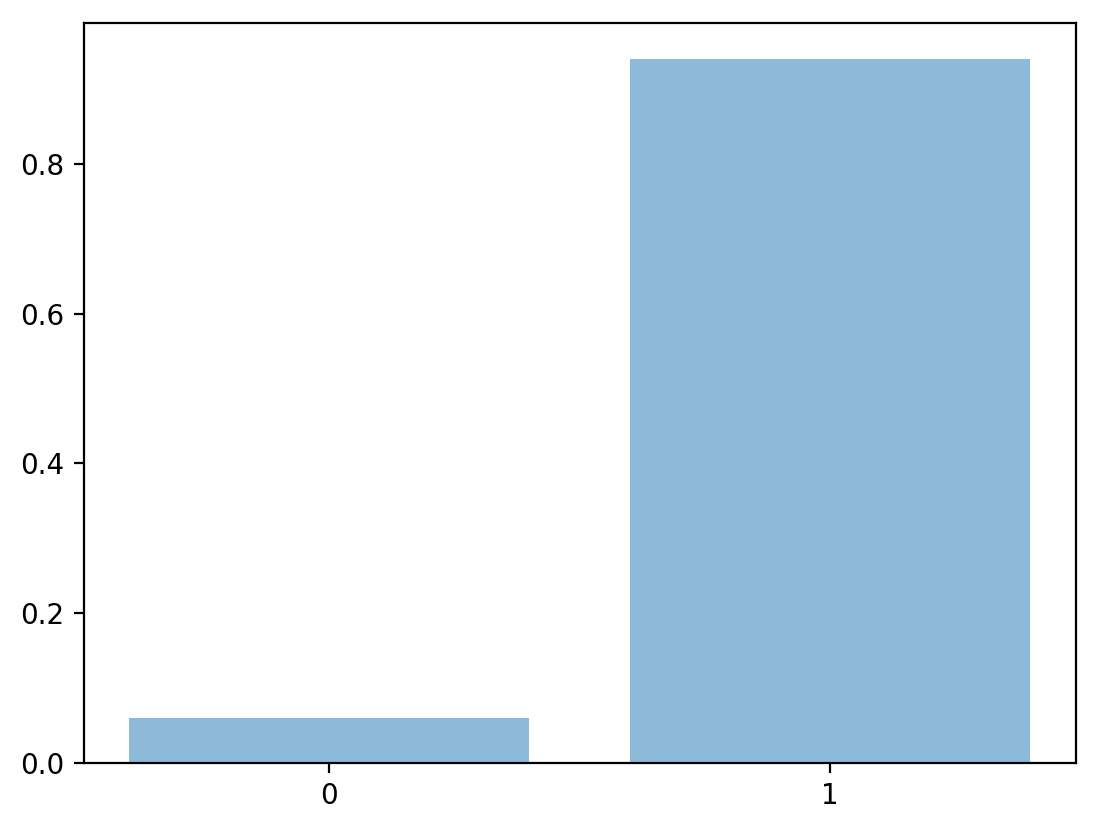

In [37]:
plt.bar([0,1], pred[0], align='center', alpha=0.5)
plt.xticks([0,1], [0,1])
plt.show()